# Preliminary

In [16]:
import numpy as np
import pandas as pd

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz, plot_tree
from sklearn.model_selection import train_test_split, cross_validate

import matplotlib.pyplot as plt
from IPython.core.display import Image 
import seaborn as sns
%matplotlib inline
import pydot
# from Ipython.core.display import Image

import os
import pydot

In [ ]:
os.chdir('/Users/justdoit/Desktop/DSL/2022-1/[정규세션 220208] Decision Tree/[정규세션 220208] Decision Tree/')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv('/content/drive/MyDrive/학회/diabetes.csv')
print(data.shape)
data.head(10)

(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


# Prepare datasets

In [4]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Draw Tree

In [5]:
clf = DecisionTreeClassifier(random_state=0)
tree_notpruned = clf.fit(X_train, y_train)


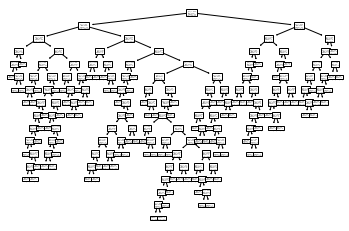

In [6]:
plot_tree(tree_notpruned)
plt.show()

In [7]:
scoring = ['f1','precision','recall']
tree_scores = cross_validate(tree_notpruned, X_train, y_train, scoring=scoring, cv=5, return_train_score = False)

print("parameter가 tuning 되지 않았을 때의 F1 Score : {:.3f}".format(np.mean(tree_scores['test_f1'])))

parameter가 tuning 되지 않았을 때의 F1 Score : 0.545


# Pruning

In [8]:
clf = DecisionTreeClassifier(random_state=0)

path = clf.cost_complexity_pruning_path(X_train, y_train)

# effective alphas, corresponding total leaf impurities 구하기
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

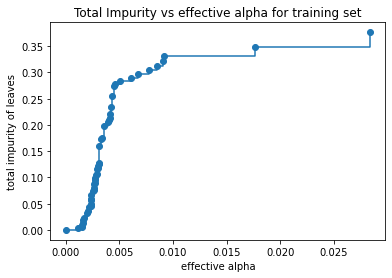

In [9]:
# effective alpha값에 따른 total impurity of leaves 그래프

fig, ax = plt.subplots()
# plt.subplots() 편의 함수는 Figure 객체를 생성하고 Figure.subplots()를 호출하여 리턴
# axes: 좌표평면을 나타내는 변수

# ccp_alphas[-1]은 노드가 하나밖에 없는 트리임.
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

# alpha 값이 커지면 트리가 작아짐 -> total impurity of leaves 커짐

In [11]:
# 함수로 만듦
def draw_decision_tree(clf, feature_names = None, class_names = None):
    dot_data = export_graphviz(clf, out_file = None, 
                                feature_names = feature_names,
                                class_names = class_names,
                                filled = True, 
                                rounded = True,
                                special_characters = True)
    graph = pydot.graph_from_dot_data(dot_data)[0]
    image = graph.create_png()
    return Image(image)

In [17]:
# effective alpha 값에 대응하는 sub-trees 시각화

clfs = []
count = 0
for ccp_alpha in ccp_alphas:
    # 각 effective alphas 이용해 decision tree 만들기
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf = clf.fit(X_train, y_train)
    count += 1
    print("Number of nodes in the {}th tree is: {} with ccp_alpha: {}".format(
      count, clf.tree_.node_count, ccp_alpha))
    display(draw_decision_tree(clf, X_train.columns, 'outcome'))
    clfs.append(clf)
    print("====================================================================================")

# ccp_alpha = 0 일 때는 not-pruned full tree
# ccp_alpha를 0부터 시작해서 크기를 늘려감, effective alpha를 지나면 가지치기
# 마지막에는 root node만 남음
# alpha에 따라서 subtree의 크기를 조정할 수 있음을 확인

Output hidden; open in https://colab.research.google.com to view.

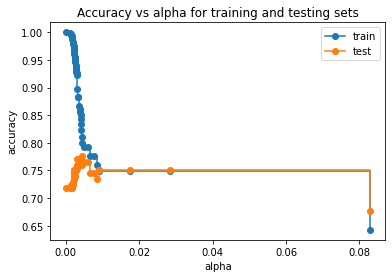

Decision tree without pruning : 215 nodes, 0.719 accuracy
Decision tree with the best pruning : 21 nodes, 0.776 accuracy


In [19]:
# testing accuracy를 높이는 최고의 ccp_alpha는?

train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

print("Decision tree without pruning : {0} nodes, {1:.3} accuracy".format(tree_notpruned.tree_.node_count, tree_notpruned.score(X_test, y_test)))
print("Decision tree with the best pruning : {0} nodes, {1:.3} accuracy".format(clfs[test_scores.index(max(test_scores))].tree_.node_count, max(test_scores)))

# 가장 높은 accuracy를 보이는 ccp_alpha 값은 약 0.013
# effective alpha = 약 0.013일 때 가장 높은 성능을 가지는 sub-tree가 만들어짐

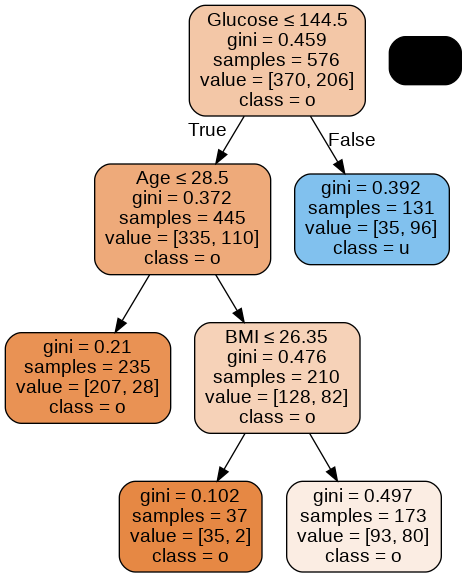

In [20]:
# testing accuracy를 높이는 최고의 ccp_alpha
clf = DecisionTreeClassifier(random_state=0, ccp_alpha=0.013)
clf = clf.fit(X_train, y_train)
draw_decision_tree(clf, X_train.columns, 'outcome')

# sub-trees 중 가장 성능 좋음
# overfitting 방지되었다고 추정